# Test 13 {#sec-test_13}
The circuit in @fig-test_13 is a ring of current sources and inductors. It turns out that this circuit is a pathological case, which generates four unknown currents steming from the four inductors and four known currents steming from the independednt current sources. When I entered this circuit into LTSpice, an error was generated saying, "the inductor L3 is in a loop involving inductor L1 and other voltage sources and/or inductors making an overdefined circuit matrix. You will need to correct the circuit or add some series resistance." So to keep LTSpice happy, I set the series resistance of L3 to 1e-20 ohms. However, the Python code did not complain about about the netlist being ill formed until I attempted to solve the circuit equations at DC, $s=0$. The current though L4 could not be dertermined. The Python code was able to generate AC solutions that agreed to LTSpice for $s \ne 0$ without the need to add a series resistance to L3.

![test circuit](test_13.png){#fig-test_13}

The netlist generated by LTSpice:
```
* test_13.asc
L1 2 3 5 Rser=0
I1 1 2 2 AC 2
L2 0 3 3 Rser=0
L3 2 1 1 Rser=1e-20
L4 1 0 1 Rser=0
I2 0 1 1
I3 3 0 5
I4 2 3 3
.op
* ;.ac list 0.159154943091895
* ;K1 L3 L2 0.5
* ;.ac dec 100 0.1 10
.backanno
.end
```

Using the orginal circuit with the series resistance in L1 set to a small value, the phase of the currents in L2 and L4 didn't agree with the Python results. So the netlist was modified to put the small series resistance in L3, which allowed the phase in L2 and L3 to agree.

The new LTSpice net list with Rser=1e-20 added to L1. 

In [1]:
#import os
from sympy import *
import numpy as np
from tabulate import tabulate
from scipy import signal
import matplotlib.pyplot as plt
import pandas as pd
import SymMNA
from IPython.display import display, Markdown, Math, Latex
init_printing()

## Load the net list
Node 5 added manually along with R1 = 1e-20 ohms in series with L1.

In [2]:
net_list = '''
*L1 2 3 5 
L1 2 4 5
R1 4 3 1e-20
I1 1 2 2 
L2 0 3 3 
L3 2 1 1 
L4 1 0 1 
I2 0 1 1
I3 3 0 5
I4 2 3 3
'''

## Call the symbolic modified nodal analysis function

In [3]:
report, network_df, i_unk_df, A, X, Z = SymMNA.smna(net_list)

Display the equations

In [4]:
# reform X and Z into Matrix type for printing
Xp = Matrix(X)
Zp = Matrix(Z)
temp = ''
for i in range(len(X)):
    temp += '${:s}$<br>'.format(latex(Eq((A*Xp)[i:i+1][0],Zp[i])))

Markdown(temp)

$- I_{L3} + I_{L4} = - I_{1} + I_{2}$<br>$I_{L1} + I_{L3} = I_{1} - I_{4}$<br>$- I_{L2} + \frac{v_{3}}{R_{1}} - \frac{v_{4}}{R_{1}} = - I_{3} + I_{4}$<br>$- I_{L1} - \frac{v_{3}}{R_{1}} + \frac{v_{4}}{R_{1}} = 0$<br>$- I_{L1} L_{1} s + v_{2} - v_{4} = 0$<br>$- I_{L2} L_{2} s - v_{3} = 0$<br>$- I_{L3} L_{3} s - v_{1} + v_{2} = 0$<br>$- I_{L4} L_{4} s + v_{1} = 0$<br>

### Netlist statistics

In [5]:
print(report)

Net list report
number of lines in netlist: 9
number of branches: 9
number of nodes: 4
number of unknown currents: 4
number of RLC (passive components): 5
number of inductors: 4
number of independent voltage sources: 0
number of independent current sources: 4
number of op amps: 0
number of E - VCVS: 0
number of G - VCCS: 0
number of F - CCCS: 0
number of H - CCVS: 0
number of K - Coupled inductors: 0



### Connectivity Matrix

In [6]:
A

⎡0   0   0    0     0      0     -1      1  ⎤
⎢                                           ⎥
⎢0   0   0    0     1      0      1      0  ⎥
⎢                                           ⎥
⎢       1    -1                             ⎥
⎢0   0  ──   ───    0     -1      0      0  ⎥
⎢       R₁    R₁                            ⎥
⎢                                           ⎥
⎢       -1   1                              ⎥
⎢0   0  ───  ──    -1      0      0      0  ⎥
⎢        R₁  R₁                             ⎥
⎢                                           ⎥
⎢0   1   0   -1   -L₁⋅s    0      0      0  ⎥
⎢                                           ⎥
⎢0   0  -1    0     0    -L₂⋅s    0      0  ⎥
⎢                                           ⎥
⎢-1  1   0    0     0      0    -L₃⋅s    0  ⎥
⎢                                           ⎥
⎣1   0   0    0     0      0      0    -L₄⋅s⎦

### Unknown voltages and currents

In [7]:
X

### Known voltages and currents

In [8]:
Z

### Network dataframe

In [9]:
network_df

,element,p node,n node,cp node,cn node,Vout,value,Vname,Lname1,Lname2
0,L1,2,4,NaN,NaN,NaN,5.0,NaN,NaN,NaN
1,R1,4,3,NaN,NaN,NaN,0.0,NaN,NaN,NaN
2,I1,1,2,NaN,NaN,NaN,2.0,NaN,NaN,NaN
3,L2,0,3,NaN,NaN,NaN,3.0,NaN,NaN,NaN
4,L3,2,1,NaN,NaN,NaN,1.0,NaN,NaN,NaN
5,L4,1,0,NaN,NaN,NaN,1.0,NaN,NaN,NaN
6,I2,0,1,NaN,NaN,NaN,1.0,NaN,NaN,NaN
7,I3,3,0,NaN,NaN,NaN,5.0,NaN,NaN,NaN
8,I4,2,3,NaN,NaN,NaN,3.0,NaN,NaN,NaN


### Unknown current dataframe

In [10]:
i_unk_df

,element,p node,n node
0,L1,2,4
1,L2,0,3
2,L3,2,1
3,L4,1,0


### Build the network equation matrix

In [11]:
# Put matrices into SymPy 
X = Matrix(X)
Z = Matrix(Z)

NE_sym = Eq(A*X,Z)
NE_sym

⎡    -I_L3 + I_L4    ⎤             
⎢                    ⎥             
⎢    I_L1 + I_L3     ⎥   ⎡-I₁ + I₂⎤
⎢                    ⎥   ⎢        ⎥
⎢          v₃   v₄   ⎥   ⎢I₁ - I₄ ⎥
⎢  -I_L2 + ── - ──   ⎥   ⎢        ⎥
⎢          R₁   R₁   ⎥   ⎢-I₃ + I₄⎥
⎢                    ⎥   ⎢        ⎥
⎢          v₃   v₄   ⎥   ⎢   0    ⎥
⎢  -I_L1 - ── + ──   ⎥ = ⎢        ⎥
⎢          R₁   R₁   ⎥   ⎢   0    ⎥
⎢                    ⎥   ⎢        ⎥
⎢-I_L1⋅L₁⋅s + v₂ - v₄⎥   ⎢   0    ⎥
⎢                    ⎥   ⎢        ⎥
⎢  -I_L2⋅L₂⋅s - v₃   ⎥   ⎢   0    ⎥
⎢                    ⎥   ⎢        ⎥
⎢-I_L3⋅L₃⋅s - v₁ + v₂⎥   ⎣   0    ⎦
⎢                    ⎥             
⎣  -I_L4⋅L₄⋅s + v₁   ⎦             

In [12]:
# turn the free symbols into SymPy variables
var(str(NE_sym.free_symbols).replace('{','').replace('}',''))

## Symbolic solution

In [13]:
U_sym = solve(NE_sym,X)

Display the symbolic solution

In [14]:
temp = ''
for i in U_sym.keys():
    temp += '${:s} = {:s}$<br>'.format(latex(i),latex(U_sym[i]))

Markdown(temp)

$v_{1} = \frac{- I_{1} L_{3} L_{4} s^{2} + I_{2} L_{1} L_{4} s^{2} + I_{2} L_{2} L_{4} s^{2} + I_{2} L_{3} L_{4} s^{2} + I_{2} L_{4} R_{1} s - I_{3} L_{2} L_{4} s^{2} - I_{4} L_{1} L_{4} s^{2} - I_{4} L_{4} R_{1} s}{L_{1} s + L_{2} s + L_{3} s + L_{4} s + R_{1}}$<br>$v_{2} = \frac{I_{1} L_{1} L_{3} s^{2} + I_{1} L_{2} L_{3} s^{2} + I_{1} L_{3} R_{1} s + I_{2} L_{1} L_{4} s^{2} + I_{2} L_{2} L_{4} s^{2} + I_{2} L_{4} R_{1} s - I_{3} L_{2} L_{3} s^{2} - I_{3} L_{2} L_{4} s^{2} - I_{4} L_{1} L_{3} s^{2} - I_{4} L_{1} L_{4} s^{2} - I_{4} L_{3} R_{1} s - I_{4} L_{4} R_{1} s}{L_{1} s + L_{2} s + L_{3} s + L_{4} s + R_{1}}$<br>$v_{3} = \frac{I_{1} L_{2} L_{3} s^{2} + I_{2} L_{2} L_{4} s^{2} - I_{3} L_{1} L_{2} s^{2} - I_{3} L_{2} L_{3} s^{2} - I_{3} L_{2} L_{4} s^{2} - I_{3} L_{2} R_{1} s + I_{4} L_{1} L_{2} s^{2} + I_{4} L_{2} R_{1} s}{L_{1} s + L_{2} s + L_{3} s + L_{4} s + R_{1}}$<br>$v_{4} = \frac{I_{1} L_{2} L_{3} s^{2} + I_{1} L_{3} R_{1} s + I_{2} L_{2} L_{4} s^{2} + I_{2} L_{4} R_{1} s - I_{3} L_{1} L_{2} s^{2} - I_{3} L_{2} L_{3} s^{2} - I_{3} L_{2} L_{4} s^{2} + I_{4} L_{1} L_{2} s^{2} - I_{4} L_{3} R_{1} s - I_{4} L_{4} R_{1} s}{L_{1} s + L_{2} s + L_{3} s + L_{4} s + R_{1}}$<br>$I_{L1} = \frac{I_{1} L_{3} s + I_{2} L_{4} s + I_{3} L_{2} s - I_{4} L_{2} s - I_{4} L_{3} s - I_{4} L_{4} s}{L_{1} s + L_{2} s + L_{3} s + L_{4} s + R_{1}}$<br>$I_{L2} = \frac{- I_{1} L_{3} s - I_{2} L_{4} s + I_{3} L_{1} s + I_{3} L_{3} s + I_{3} L_{4} s + I_{3} R_{1} - I_{4} L_{1} s - I_{4} R_{1}}{L_{1} s + L_{2} s + L_{3} s + L_{4} s + R_{1}}$<br>$I_{L3} = \frac{I_{1} L_{1} s + I_{1} L_{2} s + I_{1} L_{4} s + I_{1} R_{1} - I_{2} L_{4} s - I_{3} L_{2} s - I_{4} L_{1} s - I_{4} R_{1}}{L_{1} s + L_{2} s + L_{3} s + L_{4} s + R_{1}}$<br>$I_{L4} = \frac{- I_{1} L_{3} s + I_{2} L_{1} s + I_{2} L_{2} s + I_{2} L_{3} s + I_{2} R_{1} - I_{3} L_{2} s - I_{4} L_{1} s - I_{4} R_{1}}{L_{1} s + L_{2} s + L_{3} s + L_{4} s + R_{1}}$<br>

## Construct a dictionary of element values

In [15]:
element_values = SymMNA.get_part_values(network_df)
element_values

In [16]:
element_values

## DC operating point

In [17]:
NE_sym

⎡    -I_L3 + I_L4    ⎤             
⎢                    ⎥             
⎢    I_L1 + I_L3     ⎥   ⎡-I₁ + I₂⎤
⎢                    ⎥   ⎢        ⎥
⎢          v₃   v₄   ⎥   ⎢I₁ - I₄ ⎥
⎢  -I_L2 + ── - ──   ⎥   ⎢        ⎥
⎢          R₁   R₁   ⎥   ⎢-I₃ + I₄⎥
⎢                    ⎥   ⎢        ⎥
⎢          v₃   v₄   ⎥   ⎢   0    ⎥
⎢  -I_L1 - ── + ──   ⎥ = ⎢        ⎥
⎢          R₁   R₁   ⎥   ⎢   0    ⎥
⎢                    ⎥   ⎢        ⎥
⎢-I_L1⋅L₁⋅s + v₂ - v₄⎥   ⎢   0    ⎥
⎢                    ⎥   ⎢        ⎥
⎢  -I_L2⋅L₂⋅s - v₃   ⎥   ⎢   0    ⎥
⎢                    ⎥   ⎢        ⎥
⎢-I_L3⋅L₃⋅s - v₁ + v₂⎥   ⎣   0    ⎦
⎢                    ⎥             
⎣  -I_L4⋅L₄⋅s + v₁   ⎦             

In [18]:
NE = NE_sym.subs(element_values)
NE_dc = NE.subs({s:0})
NE_dc

⎡         -I_L3 + I_L4          ⎤   ⎡-1.0⎤
⎢                               ⎥   ⎢    ⎥
⎢          I_L1 + I_L3          ⎥   ⎢-1.0⎥
⎢                               ⎥   ⎢    ⎥
⎢-I_L2 + 1.0e+20⋅v₃ - 1.0e+20⋅v₄⎥   ⎢-2.0⎥
⎢                               ⎥   ⎢    ⎥
⎢-I_L1 - 1.0e+20⋅v₃ + 1.0e+20⋅v₄⎥   ⎢ 0  ⎥
⎢                               ⎥ = ⎢    ⎥
⎢            v₂ - v₄            ⎥   ⎢ 0  ⎥
⎢                               ⎥   ⎢    ⎥
⎢              -v₃              ⎥   ⎢ 0  ⎥
⎢                               ⎥   ⎢    ⎥
⎢           -v₁ + v₂            ⎥   ⎢ 0  ⎥
⎢                               ⎥   ⎢    ⎥
⎣              v₁               ⎦   ⎣ 0  ⎦

In [19]:
NE

⎡         -I_L3 + I_L4          ⎤   ⎡-1.0⎤
⎢                               ⎥   ⎢    ⎥
⎢          I_L1 + I_L3          ⎥   ⎢-1.0⎥
⎢                               ⎥   ⎢    ⎥
⎢-I_L2 + 1.0e+20⋅v₃ - 1.0e+20⋅v₄⎥   ⎢-2.0⎥
⎢                               ⎥   ⎢    ⎥
⎢-I_L1 - 1.0e+20⋅v₃ + 1.0e+20⋅v₄⎥   ⎢ 0  ⎥
⎢                               ⎥ = ⎢    ⎥
⎢     -5.0⋅I_L1⋅s + v₂ - v₄     ⎥   ⎢ 0  ⎥
⎢                               ⎥   ⎢    ⎥
⎢       -3.0⋅I_L2⋅s - v₃        ⎥   ⎢ 0  ⎥
⎢                               ⎥   ⎢    ⎥
⎢       -I_L3⋅s - v₁ + v₂       ⎥   ⎢ 0  ⎥
⎢                               ⎥   ⎢    ⎥
⎣         -I_L4⋅s + v₁          ⎦   ⎣ 0  ⎦

In [20]:
U_dc = solve(NE_dc,X)

In [21]:
U_dc

Display the numerical solution

Six significant digits are displayed so that results can be compared to LTSpice. 

In [22]:
table_header = ['unknown', 'mag']
table_row = []

for name, value in U_dc.items():
    table_row.append([str(name),float(value)])

print(tabulate(table_row, headers=table_header,colalign = ('left','decimal'),tablefmt="simple",floatfmt=('5s','.6f')))

unknown          mag
---------  ---------
v1          0.000000
v2          0.000000
v3          0.000000
v4          0.000000
I_L1        0.000000
I_L2        2.000000
I_L3       -1.000000
I_L4       -2.000000


The node voltages and current through the sources are solved for. The Sympy generated solution matches the LTSpice results:


```
      --- Operating Point ---

V(2):	 0	 voltage
V(3):	 0	 voltage
V(1):	 0	 voltage
I(L1):	 -1	 device_current
I(L2):	 3	 device_current
I(L3):	 0	 device_current
I(L4):	 -1	 device_current
I(I1):	 2	 device_current
I(I2):	 1	 device_current
I(I3):	 5	 device_current
I(I4):	 3	 device_current

```



### AC analysis
Solve equations for $\omega$ equal to 1 radian per second, s = 1j.
V1 is the AC source, magnitude of 10



In [23]:
element_values[I2] = 0
element_values[I3] = 0
element_values[I4] = 0

NE = NE_sym.subs(element_values)
NE_w1 = NE.subs({s:1j})
NE_w1  # display the equations

⎡         -I_L3 + I_L4          ⎤   ⎡-2.0⎤
⎢                               ⎥   ⎢    ⎥
⎢          I_L1 + I_L3          ⎥   ⎢2.0 ⎥
⎢                               ⎥   ⎢    ⎥
⎢-I_L2 + 1.0e+20⋅v₃ - 1.0e+20⋅v₄⎥   ⎢ 0  ⎥
⎢                               ⎥   ⎢    ⎥
⎢-I_L1 - 1.0e+20⋅v₃ + 1.0e+20⋅v₄⎥   ⎢ 0  ⎥
⎢                               ⎥ = ⎢    ⎥
⎢     -5.0⋅ⅈ⋅I_L1 + v₂ - v₄     ⎥   ⎢ 0  ⎥
⎢                               ⎥   ⎢    ⎥
⎢       -3.0⋅ⅈ⋅I_L2 - v₃        ⎥   ⎢ 0  ⎥
⎢                               ⎥   ⎢    ⎥
⎢       -ⅈ⋅I_L3 - v₁ + v₂       ⎥   ⎢ 0  ⎥
⎢                               ⎥   ⎢    ⎥
⎣         -ⅈ⋅I_L4 + v₁          ⎦   ⎣ 0  ⎦

In [24]:
U_w1 = solve(NE_w1,X)

Display the numerical solution

Six significant digits are displayed so that results can be compared to LTSpice. 

In [25]:
table_header = ['unknown', 'mag','phase, deg']
table_row = []

for name, value in U_w1.items():
    table_row.append([str(name),float(abs(value)),float(arg(value)*180/np.pi)])

print(tabulate(table_row, headers=table_header,colalign = ('left','decimal','decimal'),tablefmt="simple",floatfmt=('5s','.6f','.6f')))

unknown         mag    phase, deg
---------  --------  ------------
v1         0.200000    -90.000000
v2         1.600000     90.000000
v3         0.600000     90.000000
v4         0.600000     90.000000
I_L1       0.200000      0.000000
I_L2       0.200000   -180.000000
I_L3       1.800000     -0.000000
I_L4       0.200000   -180.000000



```
       --- AC Analysis ---

frequency:	0.159155	Hz
V(2):	mag:        1.6 phase:         90° 	voltage
V(3):	mag:        0.6 phase:         90° 	voltage
V(1):	mag:        0.2 phase:        -90° 	voltage
I(L1):	mag:        0.2 phase: -5.15662e-19° 	device_current
I(L2):	mag:        0.2 phase:        180° 	device_current
I(L3):	mag:        1.8 phase: 5.72958e-20° 	device_current
I(L4):	mag:        0.2 phase:        180° 	device_current
I(I1):	mag:          2 phase:          0° 	device_current
I(I2):	mag:          0 phase:          0° 	device_current
I(I3):	mag:          0 phase:          0° 	device_current
I(I4):	mag:          0 phase:          0° 	device_current

```
There are some small numeric differences in some node voltages and phases because of the series resistance. Also note the the phase of the current for L2 and L4 from LTSpice is -180 vs +180 as calculated by SymPy.  

### AC Sweep
Looking at node 21 voltage and comparing the results with those obtained from LTSpice. The frequency sweep is from 0.01 Hz to 1 Hz.

In [26]:
NE = NE_sym.subs(element_values)
NE

⎡         -I_L3 + I_L4          ⎤   ⎡-2.0⎤
⎢                               ⎥   ⎢    ⎥
⎢          I_L1 + I_L3          ⎥   ⎢2.0 ⎥
⎢                               ⎥   ⎢    ⎥
⎢-I_L2 + 1.0e+20⋅v₃ - 1.0e+20⋅v₄⎥   ⎢ 0  ⎥
⎢                               ⎥   ⎢    ⎥
⎢-I_L1 - 1.0e+20⋅v₃ + 1.0e+20⋅v₄⎥   ⎢ 0  ⎥
⎢                               ⎥ = ⎢    ⎥
⎢     -5.0⋅I_L1⋅s + v₂ - v₄     ⎥   ⎢ 0  ⎥
⎢                               ⎥   ⎢    ⎥
⎢       -3.0⋅I_L2⋅s - v₃        ⎥   ⎢ 0  ⎥
⎢                               ⎥   ⎢    ⎥
⎢       -I_L3⋅s - v₁ + v₂       ⎥   ⎢ 0  ⎥
⎢                               ⎥   ⎢    ⎥
⎣         -I_L4⋅s + v₁          ⎦   ⎣ 0  ⎦

In [27]:
U_ac = solve(NE,X)

### Plot the voltage at node 2

In [28]:
H = U_ac[v2]

In [29]:
num, denom = fraction(H) #returns numerator and denominator

# convert symbolic to numpy polynomial
a = np.array(Poly(num, s).all_coeffs(), dtype=float)
b = np.array(Poly(denom, s).all_coeffs(), dtype=float)
system = (a, b)

In [30]:
#x = np.linspace(0.1*2*np.pi, 10*2*np.pi, 2000, endpoint=True)
x = np.logspace(-1, 1, 200, endpoint=False)*2*np.pi
w, mag, phase = signal.bode(system, w=x) # returns: rad/s, mag in dB, phase in deg

Load the csv file of node 10 voltage over the sweep range and plot along with the results obtained from SymPy.

In [31]:
fn = 'test_13.csv' # data from LTSpice
LTSpice_data = np.genfromtxt(fn, delimiter=',')

In [32]:
# initaliaze some empty arrays
frequency = np.zeros(len(LTSpice_data))
voltage = np.zeros(len(LTSpice_data)).astype(complex)

# convert the csv data to complez numbers and store in the array
for i in range(len(LTSpice_data)):
    frequency[i] = LTSpice_data[i][0]
    voltage[i] = LTSpice_data[i][1] + LTSpice_data[i][2]*1j

Plot the results.  
Using

> np.unwrap(2 * phase) / 2) 

to keep the pahse plots the same.

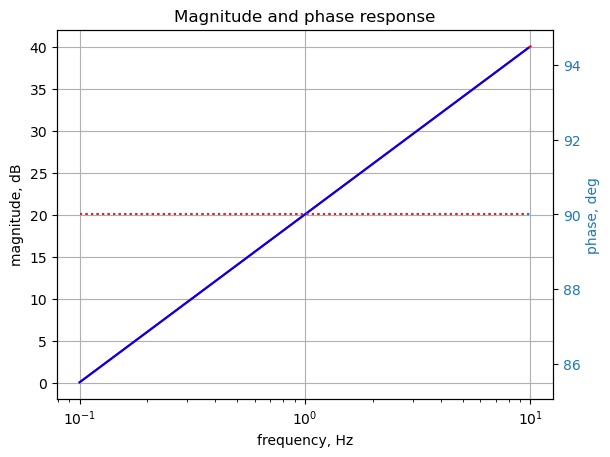

In [33]:
fig, ax1 = plt.subplots()
ax1.set_ylabel('magnitude, dB')
ax1.set_xlabel('frequency, Hz')

plt.semilogx(frequency, 20*np.log10(np.abs(voltage)),'-r')    # Bode magnitude plot
plt.semilogx(w/(2*np.pi), mag,'-b')    # Bode magnitude plot

ax1.tick_params(axis='y')
#ax1.set_ylim((-30,20))
plt.grid()

# instantiate a second y-axes that shares the same x-axis
ax2 = ax1.twinx()
color = 'tab:blue'

plt.semilogx(frequency, np.unwrap(2*np.angle(voltage)/2) *180/np.pi,':',color=color)  # Bode phase plot
plt.semilogx(w/(2*np.pi), phase,':',color='tab:red')  # Bode phase plot

ax2.set_ylabel('phase, deg',color=color)
ax2.tick_params(axis='y', labelcolor=color)
#ax2.set_ylim((-5,25))

plt.title('Magnitude and phase response')
plt.show()

The SymPy and LTSpice results overlay each other. 

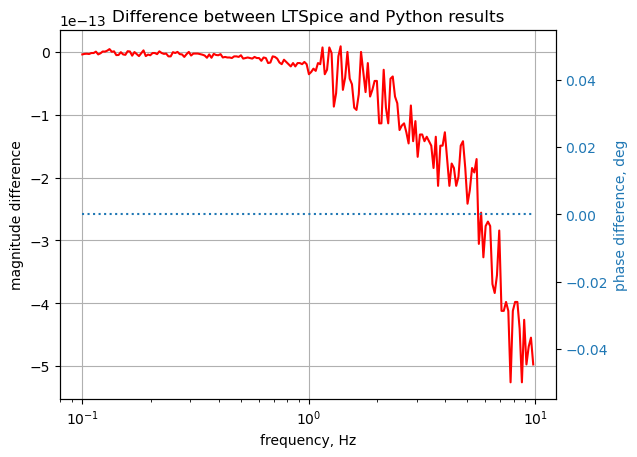

In [34]:
fig, ax1 = plt.subplots()
ax1.set_ylabel('magnitude difference')
ax1.set_xlabel('frequency, Hz')

plt.semilogx(frequency[0:-1], np.abs(voltage[0:-1])-10**(mag/20),'-r')    # Bode magnitude plot
#plt.semilogx(w/(2*np.pi), mag,'-b')    # Bode magnitude plot

ax1.tick_params(axis='y')
#ax1.set_ylim((-30,20))
plt.grid()

# instantiate a second y-axes that shares the same x-axis
ax2 = ax1.twinx()
color = 'tab:blue'

plt.semilogx(frequency[0:-1], np.unwrap(2*np.angle(voltage[0:-1])/2) *180/np.pi - phase,':',color=color)  # Bode phase plot
#plt.semilogx(w/(2*np.pi), phase,':',color='tab:red')  # Bode phase plot

ax2.set_ylabel('phase difference, deg',color=color)
ax2.tick_params(axis='y', labelcolor=color)
#ax2.set_ylim((-5,25))

plt.title('Difference between LTSpice and Python results')
plt.show()